# Demo of training a rather simple model
We hope this jupyter notebook is helpful in understanding how the evaluation is done. The model used here is a rather "bad" model. So all results on the validation sets can be thought of as lower-bound performance.

While this notebook is for demonstration, you can also run the following command to evaluate

`
python eval_server.py --pred_file pred_0.4_1.csv --gt_file ./labels/eval_full_data_0.4_1.csv --out_dir . --model_name test
`


`
python eval_server.py --pred_file pred.csv --gt_file ./grnd.csv --out_dir . --model_name test
`

import packages
------------------

Some packages are installed automatically through Anaconda. PyTorch should be also installed.

In [97]:
from __future__ import print_function, division
import random, time, copy, scipy, pickle, sys, math, gzip, html, os, ftfy, torch, json
from skimage import io, transform
import numpy as np
import os.path as path
import scipy.io as sio
from scipy import misc, ndimage, signal
import matplotlib.pyplot as plt
import PIL.Image
from io import BytesIO
from skimage import data, img_as_float

from functools import lru_cache
import pandas as pd
import seaborn as sn
import sklearn.metrics 
import regex as re

from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler 
import torch.nn.functional as F
from torch.autograd import Variable
import torchvision
from torchvision import datasets, models, transforms

from utils.dataset_OWV import *
from utils.network_arch import *
from utils.trainval import *

import warnings # ignore warnings
warnings.filterwarnings("ignore")


print(sys.version)
print(torch.__version__)
print(torch.cuda.is_available())
print(torch.version.cuda)

3.7.4 (default, Aug 13 2019, 20:35:49) 
[GCC 7.3.0]
1.7.1
True
9.2


## Setup config parameters
  
There are several things to setup, like which GPU to use, where to read images and save files, etc. Please read and understand this. By default, you should be able to run this script smoothly by changing nothing.

In [98]:
# set the random seed
torch.manual_seed(0)


# subset of validation data:
# eval_full_data_0.4_1.csv eval_full_data_0.4_2.csv eval_full_data_0.5_1.csv 
# eval_full_data_0.5_2.csv eval_full_data_0.6_1.csv eval_full_data_0.6_2.csv
curvalID = './labels_valsets/eval_full_data_0.6_2.csv'


################## set attributes for this project/experiment ##################
# config result folder
exp_dir = './exp' # experiment directory, used for reading the init model

project_name = 'dummy_model'

# set device, which gpu to use.
device ='cpu'
if torch.cuda.is_available(): 
    device='cuda:0'

nClassTotal = 414
isPretrained = False
encoder_num_layers = 18

batch_size = 64
total_epoch_num = 90 # total number of epoch in training
base_lr = 0.001 # base learning rate

torch.cuda.device_count()
torch.cuda.empty_cache()

save_dir = os.path.join(exp_dir, project_name)
print(save_dir)    
if not os.path.exists(save_dir): os.makedirs(save_dir)

log_filename = os.path.join(save_dir, 'train.log')


clsModel = ResnetEncoder(encoder_num_layers, isPretrained, embDimension=nClassTotal, poolSize=7)

./exp/dummy_model


In [99]:
################## load model ###################
path_to_classifier = os.path.join(save_dir, 'model_for_demo.paramOnly')
clsModel.load_state_dict(torch.load(path_to_classifier));
clsModel.cuda();
clsModel.to(device);
clsModel.eval();

## get testing images

2000 2000 2000
smallest class:  2.0
largest class:  200.0


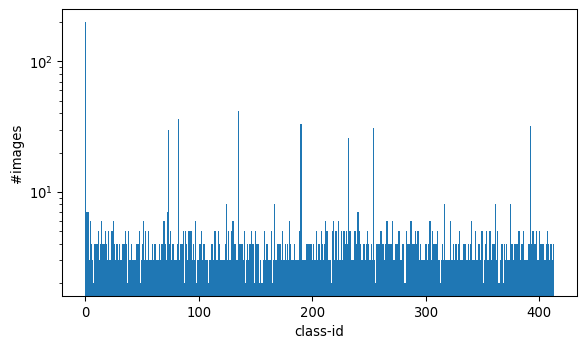

In [100]:
imageList = []
labelList = []
imagename2id = {}

file_pred = curvalID.replace('.csv', '_pred.csv')
path_to_data = '/scratch/shuk/dataset/dataset-open-world-vision-challenge'

with open(path.join(curvalID)) as fn:
    for line in fn:
        tmp = line.strip().split(',')
        if tmp[1]=='class_id': continue
        
        curname = path.join(path_to_data, 'val', tmp[0])
        curID = float(tmp[1])
        if curname in imagename2id and imagename2id[curname]==curID:
            dummy=1
        elif curname in imagename2id and imagename2id[curname]!=curID:
            print('wrong!')
        else:
            imagename2id[curname] = curID
            imageList.append(curname)
            labelList.append(curID)

print(len(imagename2id), len(labelList), len(imageList))




fig = plt.figure(figsize=(7,4), dpi=95) # better display with larger figure
counts = plt.hist(labelList, nClassTotal)
plt.yscale('log')
plt.xlabel('class-id')
plt.ylabel('#images');

print('smallest class: ', counts[0].min())
print('largest class: ', counts[0].max())


In [101]:
set_name = 'val'
datasets = {}
dataloaders = {}
datasets[set_name] = OWV_dataset(set_name=set_name, imageList=imageList, labelList=labelList, isAugment=False)
print(len(datasets[set_name]))


batch_size = 48

dataloaders[set_name] = DataLoader(
    datasets[set_name],
    batch_size=batch_size,
    shuffle=False, 
    num_workers=4) # num_work can be set to batch_size

2000


torch.Size([48, 3, 224, 224])


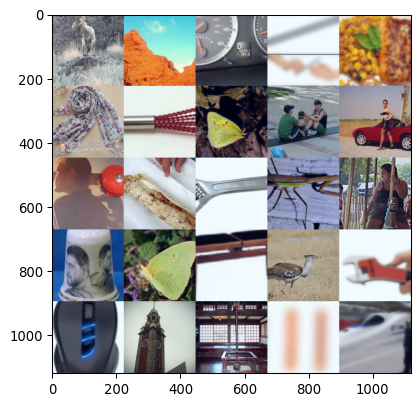

In [102]:
data_sampler = iter(dataloaders['val'])
data = next(data_sampler)
imageList224, labelList = data

imageList224 = imageList224.to(device)
labelList = labelList.type(torch.long).view(-1).to(device)

print(imageList224.shape)

imList = imageList224.permute(0,2,3,1).cpu().numpy()
imList -= imList.min()
imList /= imList.max()+0.0001
imList = createMontage(imList, (224, 224, 25))

fig = plt.figure(figsize=(5,5), dpi=95) # better display with larger figure
plt.imshow(imList)

# run the model over testing images

In [103]:
predScores = []
predList = np.array([])
grndList = np.array([])
for sample in dataloaders['val']:
    images, labels = sample
    images = images.to(device)
    labels = labels.type(torch.long).view(-1).numpy()
    with torch.no_grad(): 
        logits = clsModel(images).detach().squeeze()
        softmaxScores = F.softmax(logits, dim=1)
        
        # this is an engineering effort to tweak the likelihood of unknown detection, 
        # cf. Max of Softmax Probability in this paper: 
        # A Baseline for Detecting Misclassified and Out-of-Distribution Examples in Neural Networks
        # https://arxiv.org/abs/1610.02136
        softmaxScores[:,0] = (1-softmaxScores.max(dim=1)[0])*0.5
        
        predLabels = softmaxScores.argmax(dim=1).cpu().numpy()
        predList = np.concatenate((predList, predLabels))    
        grndList = np.concatenate((grndList, labels))
        predScores.append(softmaxScores.detach().cpu().numpy())
    
confMat = sklearn.metrics.confusion_matrix(grndList, predList)
predScores = np.concatenate(predScores, axis=0)

# normalize the confusion matrix
a = confMat.sum(axis=1).reshape((-1,1))
confMat = confMat / a

acc_avgClass = 0
for i in range(confMat.shape[0]):
    acc_avgClass += confMat[i,i]

acc_avgClass /= confMat.shape[0]
print('acc avgClass: ', acc_avgClass)

acc avgClass:  0.6301701262976976


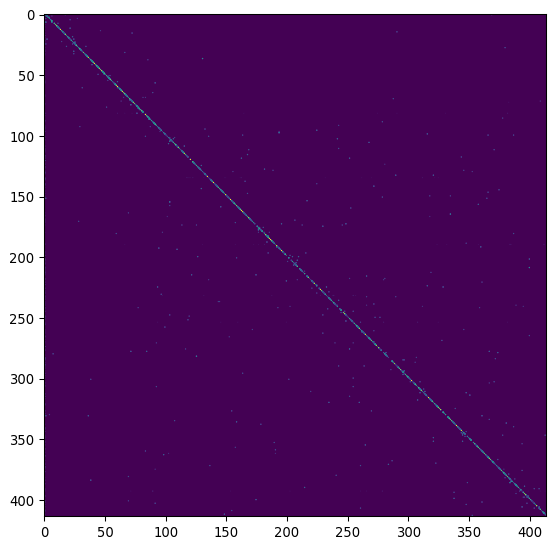

In [104]:
# a quick visual of confusion matrix
fig = plt.figure(figsize=(7,7), dpi=95) # better display with larger figure
plt.imshow(confMat)

In [105]:
print(predScores[:,0].max(), predScores[:,0].min(), predScores.max(), predScores.min())

0.48212737 0.0 1.0 0.0


# testing 
---
in command line, run the following


`
python eval_server.py --pred_file pred_eval_full_data_0.4_1.csv --gt_file ./labels/eval_full_data_0.4_1.csv --out_dir . --model_name test
`

# save the results using the following templates

Please pay special attention to how to write results to a file, which has the same format to be uploaded to EvalAI for benchmarking

In [106]:
import eval # core functions

In [107]:
file_pred = curvalID.split('/')[-1]
file_pred = file_pred.replace('eval_full_data_', 'pred_')

fn_pred = open(file_pred, 'w')

# save the results in the prediction file, which is the user uploaded file.
for i, curimagename in enumerate(imageList):
    tmp = curimagename.split('/')
    fn_pred.write('{}'.format(tmp[-1]))
    for j in range(nClassTotal):
        fn_pred.write(',{:.3f}'.format(predScores[i][j]))
    fn_pred.write('\n')

fn_pred.close()

In [108]:
# Defining column names corresponding to different novelties. These columns should be boolean
CLASS_COUNT = 414  # this is k+1 when class numbers starting from 1
GT_CLASS_COL = 'class_id'
NOVELTY_IND_COLS = [
    'instance_novelty',
    'cls_novelty',
    'attr_novelty',
    'rep_novelty',
]
METRIC_LIST = {
    'accuracy': {
        'func': eval.get_accuracy,
        'known': ['instance_novelty', 'attr_novelty', 'rep_novelty'],
        'unknown': ['cls_novelty'],
        'binary': False,
        'col_list': list(map(str, range(1, CLASS_COUNT + 1))),
        'gt_shift': 0,
    },
    'auroc_base': {
        'func': eval.roc,
        'known': ['instance_novelty'],
        'unknown': ['cls_novelty'],
        'binary': True,
        'gt_shift': 0,
    },
    'auroc_attr': {
        'func': eval.roc,
        'known': ['attr_novelty'],
        'unknown': ['cls_novelty'],
        'binary': True,
        'gt_shift': 0,
    },
    'auroc_rep': {
        'func': eval.roc,
        'known': ['rep_novelty'],
        'unknown': ['cls_novelty'],
        'binary': True,
        'gt_shift': 0,
    },
    'accuracy_base': {
        'func': eval.get_accuracy,
        'known': ['instance_novelty'],
        'unknown': [],
        'binary': False,
        'col_list': list(map(str, range(2, CLASS_COUNT + 1))),
        'gt_shift': 1,
    },
    'accuracy_attr': {
        'func': eval.get_accuracy,
        'known': ['attr_novelty'],
        'unknown': [],
        'binary': False,
        'col_list': list(map(str, range(2, CLASS_COUNT + 1))),
        'gt_shift': 1,
    },
    'accuracy_rep': {
        'func': eval.get_accuracy,
        'known': ['rep_novelty'],
        'unknown': [],
        'binary': False,
        'col_list': list(map(str, range(2, CLASS_COUNT + 1))),
        'gt_shift': 1,
    },
    'auprc_base': {
        'func': eval.pr,
        'known': ['instance_novelty'],
        'unknown': ['cls_novelty'],
        'binary': True,
        'gt_shift': 0,
    },
    'auprc_attr': {
        'func': eval.pr,
        'known': ['attr_novelty'],
        'unknown': ['cls_novelty'],
        'binary': True,
        'gt_shift': 0,
    },
    'auprc_rep': {
        'func': eval.pr,
        'known': ['rep_novelty'],
        'unknown': ['cls_novelty'],
        'binary': True,
        'gt_shift': 0,
    },
    'macro_f1_base': {
        'func': eval.macro_F1,
        'known': ['instance_novelty'],
        'unknown': ['cls_novelty'],
        'binary': False,
        'col_list': list(map(str, range(1, CLASS_COUNT + 1))),
        'gt_shift': 0,
    },
    'macro_f1_attr': {
        'func': eval.macro_F1,
        'known': ['attr_novelty'],
        'unknown': ['cls_novelty'],
        'binary': False,
        'col_list': list(map(str, range(1, CLASS_COUNT + 1))),
        'gt_shift': 0,
    },
    'macro_f1_rep': {
        'func': eval.macro_F1,
        'known': ['rep_novelty'],
        'unknown': ['cls_novelty'],
        'binary': False,
        'col_list': list(map(str, range(1, CLASS_COUNT + 1))),
        'gt_shift': 0,
    },
    'ccr_base': {
        'func': eval.ccr,
        'known': ['instance_novelty'],
        'unknown': ['cls_novelty'],
        'binary': False,
        'col_list': list(map(str, range(1, CLASS_COUNT + 1))),
        'gt_shift': 0,
    },
    'ccr_attr': {
        'func': eval.ccr,
        'known': ['attr_novelty'],
        'unknown': ['cls_novelty'],
        'binary': False,
        'col_list': list(map(str, range(1, CLASS_COUNT + 1))),
        'gt_shift': 0,
    },
    'ccr_rep': {
        'func': eval.ccr,
        'known': ['rep_novelty'],
        'unknown': ['cls_novelty'],
        'binary': False,
        'col_list': list(map(str, range(1, CLASS_COUNT + 1))),
        'gt_shift': 0,
    },
}

In [109]:
def filter_data(data, novelties=None):
    """filters the dataframe based on given novelty columns. Basically it will include rows which have
    value=1 in the specified novelty columns and value!=1 in rest of NOVELTY_IND_COLUMNS
    Args:
        data (pd.DataFrame): input data frame
        novelties (list of str): list of novelty columns which should specify the novelty type
    Returns:
        filtered_data (pd.DataFrame): filtered data based on above logic
    """
    assert novelties is not None and isinstance(novelties, list), 'novelties variable should be a list'
    filter_query = '('  # building query for dynamic evaluation on a dataframe
    for novelty in novelties:
        assert novelty in NOVELTY_IND_COLS, f'Unsupported novelty column. Available options are ' \
                                            f'{",".join(NOVELTY_IND_COLS)}'
        filter_query += f'{novelty} == 1 | '
    if len(filter_query) > 1:
        filter_query = filter_query[:filter_query.rfind('|')] + ') &'
    else:
        filter_query = ''
    if len(novelties) > 0:
        for novelty in list(set(NOVELTY_IND_COLS) - set(novelties)):
            filter_query += f'{novelty} != 1 & '
    else:
        for novelty in NOVELTY_IND_COLS:
            filter_query += f'{novelty} != 1 & '
    if len(filter_query) > 0:
        filter_query = filter_query[:filter_query.rfind('&')]
    filtered_data = data.query(filter_query)
    return filtered_data


def evaluate(pred_file, gt_file):
    """Main function that calculates all the metrics on server side
    Args:
        pred_file (str): path to csv file containing pred labels
            Column 0 - file name
            Column 1..n - probability of data point being class 'n'. The last column will be considers as unknown class
        gt_file (str): path to csv file containing gt labels for each data point.
            Column 0 - file name
            Other columns will be accessed by name
    """
    assert os.path.isfile(pred_file), f'File not found: {pred_file}'
    assert os.path.isfile(gt_file), f'File not found: {gt_file}'

    gt_df = pd.read_csv(gt_file)
    # TODO Implement checks on format of pred file.
    pred_df = pd.read_csv(pred_file,
                          header=None,
                          index_col=None,
                          names=['path'] + list(map(str, range(1, CLASS_COUNT + 1))))

    results = dict()
    for metric in METRIC_LIST:
        unknown_data = filter_data(gt_df, METRIC_LIST[metric]['unknown'])
        unknown_data['binary_class'] = 1  # 1 - Unknown, 0 - Known
        unknown_data[GT_CLASS_COL] = 0  # We will always assign 0 to unknown class in multi class case
        known_data = filter_data(gt_df, METRIC_LIST[metric]['known'])
        known_data['binary_class'] = 0
        gt_data = pd.concat([unknown_data, known_data])
        data = gt_data.join(pred_df, how='inner', lsuffix='gt_', rsuffix='pred_')
        if METRIC_LIST[metric]['binary']:
            labels = np.asarray(data['binary_class'])
            preds = np.asarray(data[str(1)])  # Unknown probabilities should be the first column
        else:
            labels = np.asarray(data[GT_CLASS_COL])
            preds = np.asarray(data[METRIC_LIST[metric]['col_list']])
        results[metric] = METRIC_LIST[metric]['func'](preds, labels, gt_shift=METRIC_LIST[metric]['gt_shift'])
    return results


In [110]:
file_grnd = curvalID
file_pred = file_pred
out_dir = './'

results = evaluate(file_pred, file_grnd)
json.dump(results, open(path.join(out_dir, file_pred.replace('.csv','.json')), 'w'))

In [111]:
results.keys()

dict_keys(['accuracy', 'auroc_base', 'auroc_attr', 'auroc_rep', 'accuracy_base', 'accuracy_attr', 'accuracy_rep', 'auprc_base', 'auprc_attr', 'auprc_rep', 'macro_f1_base', 'macro_f1_attr', 'macro_f1_rep', 'ccr_base', 'ccr_attr', 'ccr_rep'])

### primary metrics: accuracy over all the (K+1) classes

In [112]:
top1avgClasses, top5avgClasses = 0, 0
for i in range(CLASS_COUNT):
    top1avgClasses+=results['accuracy'][1][i]
    top5avgClasses+=results['accuracy'][5][i]
    
top1avgClasses /= CLASS_COUNT
top5avgClasses /= CLASS_COUNT

print('macro-average accuracy on all testing examples from (K+1) classes, the top-1 / 5 accuracies are {:.4f} / {:.4f}'.format(
    top1avgClasses, top5avgClasses))

print('micro-average accuracy on all testing examples from (K+1) classes, the top-1 / 5 accuracies are {:.4f} / {:.4f}'.format(
    results['accuracy'][1]['all'], results['accuracy'][5]['all']))

macro-average accuracy on all testing examples from (K+1) classes, the top-1 / 5 accuracies are 0.6302 / 0.8172
micro-average accuracy on all testing examples from (K+1) classes, the top-1 / 5 accuracies are 0.5510 / 0.7880


### breakdown analysis w.r.t classification accuracies on known examples

In [113]:
top1avgClasses_base, top5avgClasses_base = 0, 0
top1avgClasses_attr, top5avgClasses_attr = 0, 0
top1avgClasses_rep, top5avgClasses_rep = 0, 0

count_base, count_attr, count_rep = 0, 0, 0


for i in range(1,CLASS_COUNT):
    if i in results['accuracy_base'][1]:
        top1avgClasses_base+=results['accuracy_base'][1][i]
        top5avgClasses_base+=results['accuracy_base'][5][i]
        count_base += 1
    if i in results['accuracy_attr'][1]:
        top1avgClasses_attr+=results['accuracy_attr'][1][i]
        top5avgClasses_attr+=results['accuracy_attr'][5][i]
        count_attr += 1
    if i in results['accuracy_rep'][1]:
        top1avgClasses_rep+=results['accuracy_rep'][1][i]
        top5avgClasses_rep+=results['accuracy_rep'][5][i]
        count_rep += 1
    
top1avgClasses_base /= count_base
top5avgClasses_base /= count_base
top1avgClasses_attr /= count_attr
top5avgClasses_attr /= count_attr
top1avgClasses_rep /= count_rep
top5avgClasses_rep /= count_rep

print('macro-average top-1 / 5 accuracy on K-known-class examples that have no modifications: {:.4f} / {:.4f}'.format(
    top1avgClasses_base, top5avgClasses_base))
print('macro-average top-1 / 5 accuracy on K-known-class examples that have novel attributes: {:.4f} / {:.4f}'.format(
    top1avgClasses_attr, top5avgClasses_attr))
print('macro-average top-1 / 5 accuracy on K-known-class examples that have novel augmentations: {:.4f} / {:.4f}'.format(
    top1avgClasses_rep, top5avgClasses_rep))

macro-average top-1 / 5 accuracy on K-known-class examples that have no modifications: 0.7167 / 0.8866
macro-average top-1 / 5 accuracy on K-known-class examples that have novel attributes: 0.2608 / 0.4664
macro-average top-1 / 5 accuracy on K-known-class examples that have novel augmentations: 0.4241 / 0.6291


In [114]:
print('micro-average top-1 / 5 accuracy on K-known-class examples that have no modifications: {:.4f} / {:.4f}'.format(
    results['accuracy_base'][1]['all'], results['accuracy_base'][5]['all']))
print('micro-average top-1 / 5 accuracy on K-known-class examples that have novel attributes: {:.4f} / {:.4f}'.format(
    results['accuracy_attr'][1]['all'], results['accuracy_base'][5]['all']))
print('micro-average top-1 / 5 accuracy on K-known-class examples that have novel augmentations: {:.4f} / {:.4f}'.format(
    results['accuracy_rep'][1]['all'], results['accuracy_base'][5]['all']))

micro-average top-1 / 5 accuracy on K-known-class examples that have no modifications: 0.7150 / 0.8850
micro-average top-1 / 5 accuracy on K-known-class examples that have novel attributes: 0.2450 / 0.8850
micro-average top-1 / 5 accuracy on K-known-class examples that have novel augmentations: 0.4300 / 0.8850


### Precision Recall for unknown example detection
https://scikit-learn.org/stable/auto_examples/model_selection/plot_precision_recall.html

In [115]:
print('discrimination of unknown-class examples vs. known-class examples that have no modifications (AUPR): {:.4f}'.format(
    results['auprc_base']['auc']))
print('discrimination of unknown-class examples vs. known-class examples that have novel attributes (AUPR): {:.4f}'.format(
    results['auprc_attr']['auc']))
print('discrimination of unknown-class examples vs. known-class examples that have novel augmentations (AUPR): {:.4f}'.format(
    results['auprc_rep']['auc']))

discrimination of unknown-class examples vs. known-class examples that have no modifications (AUPR): 0.3419
discrimination of unknown-class examples vs. known-class examples that have novel attributes (AUPR): 0.5549
discrimination of unknown-class examples vs. known-class examples that have novel augmentations (AUPR): 0.3028


### Area under ROC curve (AUROC) for unknown example detection
https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html

In [116]:
print('detection of unknown examples from known examples that have no modifications (AUROC): {:.4f}'.format(
    results['auroc_base']['auc']))
print('detection of unknown examples from known examples that have novel attributes (AUROC): {:.4f}'.format(
    results['auroc_attr']['auc']))
print('detection of unknown examples from known examples that have novel augmentations (AUROC): {:.4f}'.format(
    results['auroc_rep']['auc']))

detection of unknown examples from known examples that have no modifications (AUROC): 0.7931
detection of unknown examples from known examples that have novel attributes (AUROC): 0.5655
detection of unknown examples from known examples that have novel augmentations (AUROC): 0.4963


### Macro-average F1 over (K+1) classes
https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html

In [117]:
print('macro-average F1 over (K+1) classes on examples that have no modifications: {:.4f}'.format(results['macro_f1_base']))
print('macro-average F1 over (K+1) classes on examples that have novel attributes: {:.4f}'.format(results['macro_f1_attr']))
print('macro-average F1 over (K+1) classes on examples that have novel augmentations: {:.4f}'.format(results['macro_f1_rep']))

macro-average F1 over (K+1) classes on examples that have no modifications: 0.6817
macro-average F1 over (K+1) classes on examples that have novel attributes: 0.0193
macro-average F1 over (K+1) classes on examples that have novel augmentations: 0.3107


### Correct Classification Rate (CCR)
https://github.com/Vastlab/Reducing-Network-Agnostophobia/blob/master/Tools/evaluation_tools.py

In [118]:
print('AUC of CCR-FPR curve on examples in which known-class examples have no modifications: {:.4f}'.format(results['ccr_base']['auc']))
print('AUC of CCR-FPR curve on examples in which known-class examples have novel attributes: {:.4f}'.format(results['ccr_attr']['auc']))
print('AUC of CCR-FPR curve on examples in which known-class examples have novel augmentations: {:.4f}'.format(results['ccr_rep']['auc']))

AUC of CCR-FPR curve on examples in which known-class examples have no modifications: 0.6356
AUC of CCR-FPR curve on examples in which known-class examples have novel attributes: 0.1911
AUC of CCR-FPR curve on examples in which known-class examples have novel augmentations: 0.3112


In [119]:
token = 'ccr_base'

idx = 2 # fpr=0.01
curFPR = results[token]['fpr'][idx]
print('CCR@FPR={:.2f} on examples in which known-class examples have no modifications: {:.4f}'.format(
    curFPR, results[token]['ccr'][idx]))
idx = 14 # fpr=0.01
curFPR = results[token]['fpr'][idx]
print('CCR@FPR={:.2f} on examples in which known-class examples have no modifications: {:.4f}'.format(
    curFPR, results[token]['ccr'][idx]))
idx = 29 # fpr=0.01
curFPR = results[token]['fpr'][idx]
print('CCR@FPR={:.2f} on examples in which known-class examples have no modifications: {:.4f}'.format(
    curFPR, results[token]['ccr'][idx]))
print('\n')


token = 'ccr_attr'

idx = 2 # fpr=0.01
curFPR = results[token]['fpr'][idx]
print('CCR@FPR={:.2f} on examples in which known-class examples have novel attributes: {:.4f}'.format(
    curFPR, results[token]['ccr'][idx]))
idx = 14 # fpr=0.01
curFPR = results[token]['fpr'][idx]
print('CCR@FPR={:.2f} on examples in which known-class examples have novel attributes: {:.4f}'.format(
    curFPR, results[token]['ccr'][idx]))
idx = 29 # fpr=0.01
curFPR = results[token]['fpr'][idx]
print('CCR@FPR={:.2f} on examples in which known-class examples have novel attributes: {:.4f}'.format(
    curFPR, results[token]['ccr'][idx]))
print('\n')


token = 'ccr_rep'

idx = 2 # fpr=0.01
curFPR = results[token]['fpr'][idx]
print('CCR@FPR={:.2f} on examples in which known-class examples have novel augmentations: {:.4f}'.format(
    curFPR, results[token]['ccr'][idx]))
idx = 14 # fpr=0.01
curFPR = results[token]['fpr'][idx]
print('CCR@FPR={:.2f} on examples in which known-class examples have novel augmentations: {:.4f}'.format(
    curFPR, results[token]['ccr'][idx]))
idx = 29 # fpr=0.01
curFPR = results[token]['fpr'][idx]
print('CCR@FPR={:.2f} on examples in which known-class examples have novel augmentations: {:.4f}'.format(
    curFPR, results[token]['ccr'][idx]))

CCR@FPR=0.01 on examples in which known-class examples have no modifications: 0.3717
CCR@FPR=0.07 on examples in which known-class examples have no modifications: 0.5017
CCR@FPR=0.15 on examples in which known-class examples have no modifications: 0.5467


CCR@FPR=0.01 on examples in which known-class examples have novel attributes: 0.1150
CCR@FPR=0.07 on examples in which known-class examples have novel attributes: 0.1350
CCR@FPR=0.15 on examples in which known-class examples have novel attributes: 0.1500


CCR@FPR=0.01 on examples in which known-class examples have novel augmentations: 0.1125
CCR@FPR=0.07 on examples in which known-class examples have novel augmentations: 0.1825
CCR@FPR=0.15 on examples in which known-class examples have novel augmentations: 0.2175


In [120]:
['macro top1 accuracy (K+1)', 'macro top5 accuracy (K+1)', 'micro top1 accuracy (K+1)', 'micro top5 accuracy (K+1)', 
 'macro top1 accuracy K-known w/o modifications', 'macro top5 accuracy K-known w/o modifications', 
 'macro top1 accuracy K-known w/ novel attributes', 'macro top5 accuracy K-known w/ novel attributes', 
 'macro top1 accuracy K-known w/ novel augmentations', 'macro top5 accuracy K-known w/ novel augmentations', 
 'micro top1 accuracy K-known w/o modifications', 'micro top5 accuracy K-known w/o modifications', 
 'micro top1 accuracy K-known w/ novel attributes', 'micro top5 accuracy K-known w/ novel attributes', 
 'micro top1 accuracy K-known w/ novel augmentations', 'micro top5 accuracy K-known w/ novel augmentations',
 'unknown detection from known w/o modifications (AUPR)', 'unknown detection from known w/ novel attributes (AUPR)', 
 'unknown detection from known w/ novel augmentations (AUPR)', 'unknown detection from known w/o modifications (AUROC)', 
 'unknown detection from known w/ novel attributes (AUROC)', 'unknown detection from known w/ novel augmentations (AUROC)', 
 'macro-average F1 over (K+1) classes w/o modifications', 'macro-average F1 over (K+1) classes w/ novel attributes', 
 'macro-average F1 over (K+1) classes w/ novel augmentations', 'AUC of CCR-FPR w/o modifications', 
 'AUC of CCR-FPR w/ novel attributes', 'AUC of CCR-FPR w/ novel augmentations', 
 'AUC of CCR-FPR w/o modifications (@FPR=0.01)', 
 'AUC of CCR-FPR w/o modifications (@FPR=0.05)', 'AUC of CCR-FPR w/o modifications (@FPR=0.10)', 
 'AUC of CCR-FPR w/ novel attributes (@FPR=0.01)', 'AUC of CCR-FPR w/ novel attributes (@FPR=0.05)', 
 'AUC of CCR-FPR w/ novel attributes (@FPR=0.10)', 'AUC of CCR-FPR w/ novel augmentations (@FPR=0.01)', 
 'AUC of CCR-FPR w/ novel augmentations (@FPR=0.05)', 'AUC of CCR-FPR w/ novel augmentations (@FPR=0.10)']


['macro top1 accuracy (K+1)',
 'macro top5 accuracy (K+1)',
 'micro top1 accuracy (K+1)',
 'micro top5 accuracy (K+1)',
 'macro top1 accuracy K-known w/o modifications',
 'macro top5 accuracy K-known w/o modifications',
 'macro top1 accuracy K-known w/ novel attributes',
 'macro top5 accuracy K-known w/ novel attributes',
 'macro top1 accuracy K-known w/ novel augmentations',
 'macro top5 accuracy K-known w/ novel augmentations',
 'micro top1 accuracy K-known w/o modifications',
 'micro top5 accuracy K-known w/o modifications',
 'micro top1 accuracy K-known w/ novel attributes',
 'micro top5 accuracy K-known w/ novel attributes',
 'micro top1 accuracy K-known w/ novel augmentations',
 'micro top5 accuracy K-known w/ novel augmentations',
 'unknown detection from known w/o modifications (AUPR)',
 'unknown detection from known w/ novel attributes (AUPR)',
 'unknown detection from known w/ novel augmentations (AUPR)',
 'unknown detection from known w/o modifications (AUROC)',
 'unknown de